In [3]:
!pip install graphviz

In [4]:
# визуализировать дерево можно посредством библиотеки python-graphviz
from graphviz import Digraph
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='Клиент старше 18 лет?')
dot.node('B', label='Превышает ли его заработок 50 тысяч рублей?')
dot.node('C', label='Отказать')
dot.node('D', label='Были ли у клиента просроченные кредиты ранее?')
dot.node('E', label='Отказать')
dot.node('F', label='Отказать')
dot.node('G', label='Выдать')

dot.edge('A', 'B', label='да')
dot.edge('A', 'C', label='нет')
dot.edge('B', 'D', label='да')
dot.edge('B', 'E', label='нет')
dot.edge('D', 'F', label='да')
dot.edge('D', 'G', label='нет')

dot

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [5]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

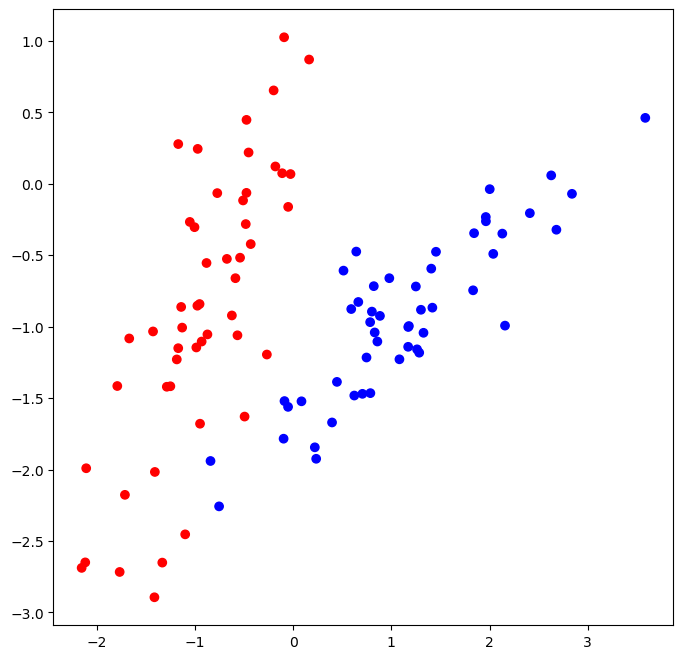

In [6]:
# сгенерируем и визуализируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.show()

In [7]:
# Реализуем класс узла

class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# Реализуем класс листа листа

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        prediction = np.argmax(np.bincount(self.labels))

        return prediction

In [8]:
# Расчёт критерия Джини
# просто формула, нужна чтобы посчитать формулу кволити

def gini(labels):
    classes, counts = np.unique(labels, return_counts=True)
    impurity = 0
    for count in counts:
      impurity += (count/len(labels)) * (1 - count/len(labels))
    return impurity

In [9]:
# Расчет качества просто по формуле

def quality(left_labels, right_labels, current_gini):
    left_coef = len(left_labels) / (len(left_labels) + len(right_labels))
    return current_gini - left_coef * gini(left_labels) - (1-left_coef) * gini(right_labels)

In [10]:
def split(data, labels, index, t):

    true_indices = np.where(data[:, index] < t)[0]
    false_indices = np.where(data[:, index] >= t)[0]

    return data[true_indices], data[false_indices], labels[true_indices], labels[false_indices]

In [11]:
# Нахождение наилучшего разбиения
# на каждом шаге ищем лучший порог и хотим наибольшее кволити. самый лучший порог там где кволити наибольшее
# перебрать все сплиты и найти лучший
# кволити равно нулю изначально

def find_best_split(data, labels):
    # Обозначим минимальное количество объектов в узле
    min_leaf = 5
    best_quality = 0
    best_t = 0
    best_index = 0

    current_gini = gini(labels)

    for index in range(data.shape[1]):
        for t in np.unique(data[:, index]):
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue

            this_quality = quality(true_labels, false_labels, current_gini)

            if this_quality > best_quality:
                best_quality = this_quality
                best_t = t
                best_index = index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева посредством рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
# Проход объекта по дереву для его классификации
# если больше порога, то в одну ветку, меньше в другую (на каждом этапе)

def classify_object(obj, node):

    if isinstance(node, Leaf):
      return node.prediction

    if(obj[node.index] < node.t):
      return classify_object(obj, node.true_branch)

    else:
      return classify_object(obj, node.false_branch)

In [14]:
# Предсказание деревом для всего датасета

def predict(data, tree):

    predictions = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        predictions[i] = classify_object(data[i], tree)
    return predictions

In [15]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [16]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [17]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(my_tree)

Индекс 0
Порог 0.22079911434425847
--> True:
  Индекс 1
  Порог -1.4172393321608008
  --> True:
    Индекс 0
    Порог -0.8411814419026544
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [18]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)
# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [19]:
# Введем функцию подсчета точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

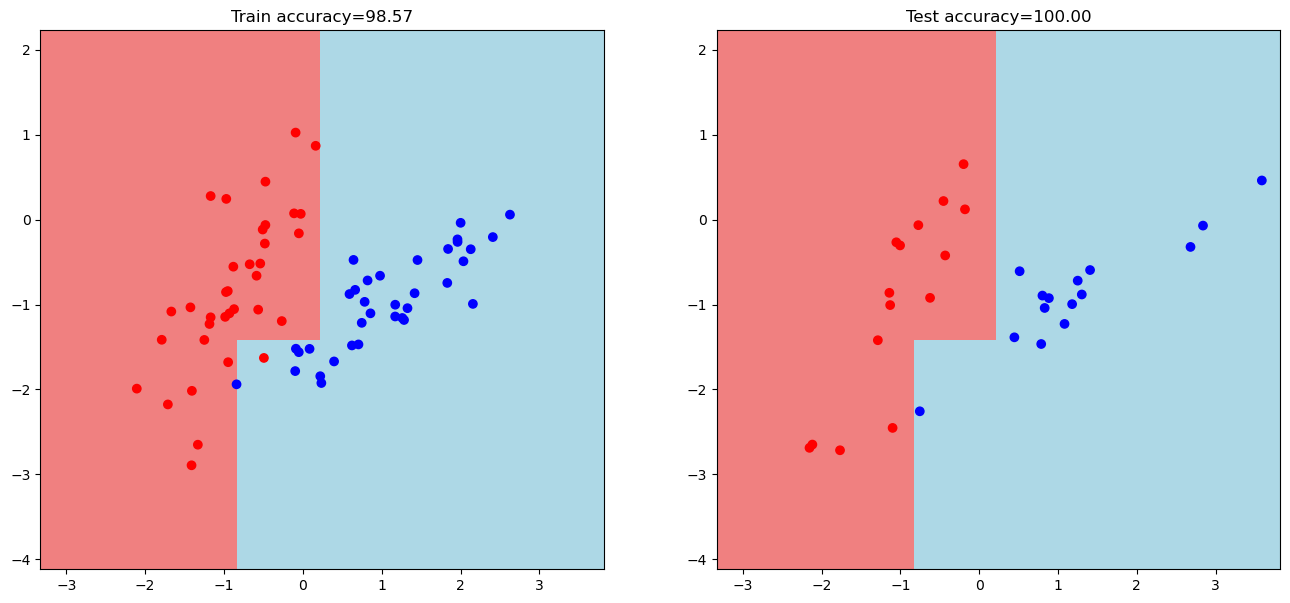

In [20]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

#print(np.c_[xx.ravel(), yy.ravel()])

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [21]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка данных
iris = load_iris()
X, y = iris.data, iris.target

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)

clf.fit(X_train, y_train)

# Предсказание и оценка качества модели
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy:.2f}')

Точность модели: 1.00
